I am going to be using the 1990 California Housing Prices dataset gotten from the California census to build a model of housing values.  I will be following the Machine Learning Project Checklist found in "Hands-On Machine learning with Scikit-Learn and Tensorflow" also following along with same book.

# Frame the Problem and Look at Big Picture

**What benefits will this model provide?**  The model will be used to determine whether houses in a given area are worth investing in or not.

Let's identify what type of problem this is: 
- It is a **supervised learning** problem since we have labeled training data
- **Regression task** since we are just predicting the value of the homes
- Should use **batch learning** because the data is small enough to keep in memory, and since this is old data, we don't have a steady flow of it coming in


**What type of performance measure should we use?**  We will use Root Mean Square Error (RMSE)

**Check the assumptions** Since we are using this to model housing values, this could be plugged into another machine learning model.  This other model might be converting prices into categories such as cheap, medium, or expensive.  In this case, it would transform this into a classification task instaed.  But we are going to assume that our model will be used soley to predict the actual values, therefore keeping this as a regression task.

# Get the Data 

Source: https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [99]:
import pandas as pd

housing = pd.read_csv("housing.csv",)
housing.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue,oceanProximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**NOTE** Each row represents a single block group/district.  A district is the smallest geographical unit for which the US Census Bureau publishes sample data, usually having a population between 600-3,000 people

In [100]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude           20640 non-null float64
latitude            20640 non-null float64
housingMedianAge    20640 non-null float64
totalRooms          20640 non-null float64
totalBedrooms       20433 non-null float64
population          20640 non-null float64
households          20640 non-null float64
medianIncome        20640 non-null float64
medianHouseValue    20640 non-null float64
oceanProximity      20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Seems that totalBedrooms is missing 207 instances, will take care of this later

oceanProximity is the non float field, let's look at what it contains

In [101]:
housing.oceanProximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: oceanProximity, dtype: int64

Let's also look at some info on the other features

In [102]:
housing.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


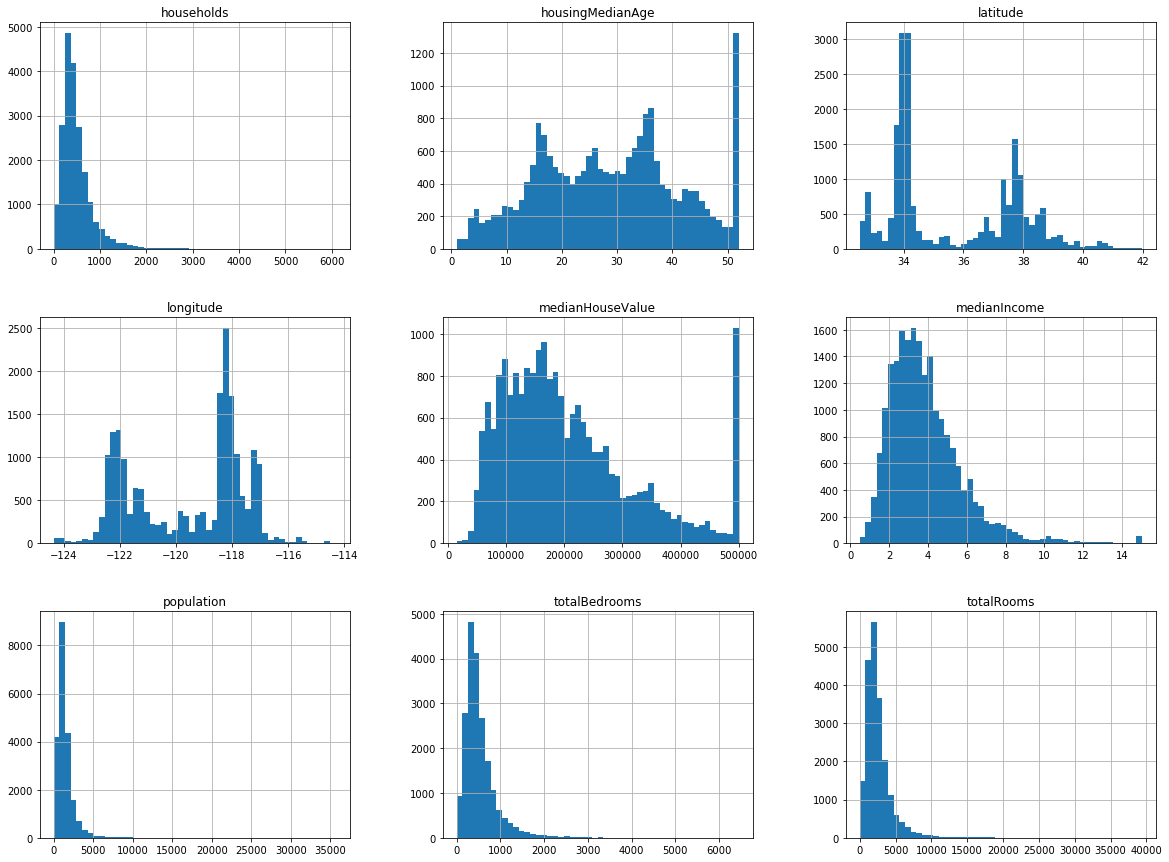

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

First thing to notice, the medianIncome does not seem to be in regular USD.  It has been scaled and is capped at about 15 for higher median incomes and .5 for lower median incomes.

The medianAge and medianHouseValue features have also been capped.  Since medianHouseValue is out target, we might have a problem.  For someone using our model to predict if they should invest or not, being capped at 500k dollars will cause major problems if they need percision beyond that.  So we can do two things:
- Get the actual labels for the instances that were capped
- Remove any instance > 500k dollars

Since these 3 features have totally different scales, we will need to revisit this with feature scaling later

Many of these histograms are tail-heavy which can cause problems for ML algorithms trying to detect patterns.  Later, we will transform these features so that we have more of a bell-shaped curve

**Create a test set**

In [104]:
from sklearn.model_selection import train_test_split

trainSet, testSet = train_test_split(housing, test_size=0.2, random_state=42)

These train and test sets were done using random sampling. Most of the time this is fine, but sometimes it can lead to sampling bias. We want to make sure that our test set is a true representation of our whole population. So we use something called stratified sampling. Suppose someone told us that median income was a key feature in determining median house value, then we make sure that our test set is truly representative of the varies median incomes

Let's create a new category called incomeCategory and derive it by dividing the medianIncome by 1.5 so that we limit the number or categories.  We will then round up using numpy's ceil and make sure that we have discrete categories between 1 and 5

In [105]:
import numpy as np

housing["incomeCategory"] = np.ceil(housing.medianIncome / 1.5)
housing.incomeCategory.where(housing.incomeCategory < 5, 5.0, inplace=True)

In [106]:
housing.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue,oceanProximity,incomeCategory
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Now let's do stratified sampling based on the incomeCategory

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for trainIndex, testIndex in split.split(housing, housing.incomeCategory):
    stratTrainSet = housing.loc[trainIndex]
    stratTestSet = housing.loc[testIndex]

Let's see how this worked by looking at the proportions in the full dataset:

In [108]:
housing.incomeCategory.value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: incomeCategory, dtype: float64

In [109]:
def incomeCategoryProportions(data):
    return data.incomeCategory.value_counts() / len(data)

trainSet, testSet = train_test_split(housing, test_size=0.2, random_state=42)

compareProportions = pd.DataFrame({
    "Overall": incomeCategoryProportions(housing),
    "Stratified": incomeCategoryProportions(stratTestSet),
    "Random": incomeCategoryProportions(testSet),
}).sort_index()

compareProportions["Rand. %error"] = 100 * compareProportions["Random"] / compareProportions["Overall"] - 100
compareProportions["Strat. %error"] = 100 * compareProportions["Stratified"] / compareProportions["Overall"] - 100

compareProportions

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


As you can see above, when we used random sampling, we had a much higher error rate as to that of the stratified sampling.  The stratified sampling was actually nearly identical.  Stratified sampling is not always needed, especially when the dataset is very large.  But sometimes it can create significan bias

Now we should remove the incomeCategory so our data is back to its original state

In [110]:
for set in (stratTrainSet, stratTestSet):
    set.drop(["incomeCategory"], axis=1, inplace=True)

# Explore the Data 

Let's first create a copy of the training set so we don't mess anything up

In [111]:
housing = stratTrainSet.copy()

Now let's visualize the data via latitude and logitute

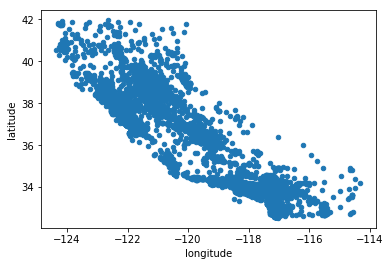

In [112]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Can't really tell where the highest desnsity of datapoints are, so we will replot with an alpha of 0.1

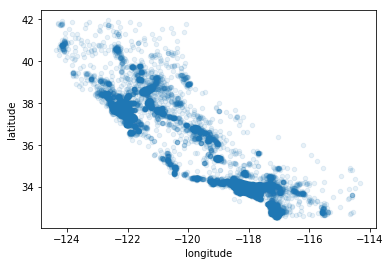

In [113]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

Now we can see that there is a high desnsity of data points in the Bay Area and Central Valley.  Now let's look at housing prices:

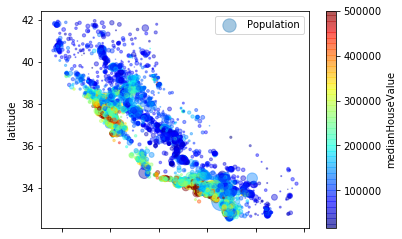

In [114]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing.population/100, label="Population",
             c="medianHouseValue", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

The radius of the circles tell us the disctric's population and color is price.  By looking at this plot, we can tell that prices are very much related to location relative to the ocean (duh!), as well as to the population density.  

It might be useful to use a clustering algorithm to detect main clusters and add new features that measure proximity to the cluster centers.  

**Look for corelations**

Since our dataset isn't large, we can compute the standard correlation coefficient

In [115]:
correlationMatrix = housing.corr()

correlationMatrix.medianHouseValue.sort_values(ascending=False)

medianHouseValue    1.000000
medianIncome        0.687160
totalRooms          0.135097
housingMedianAge    0.114110
households          0.064506
totalBedrooms       0.047689
population         -0.026920
longitude          -0.047432
latitude           -0.142724
Name: medianHouseValue, dtype: float64

As we can see, there seems to be a high strong positive correlation between value and income.  This makes sense because as you make more money, you can usually afford a nicer house.  We can also see a somewhat weak negative correlation between value and latitude; which makes sense since we can see in the abover graph that as latitude increase (aka we move north) price tends to decrease

**NOTE** the correlation coefficient only measures linear correlations 

We can also visualize the correlation with Pandas.  I will just select a few for this

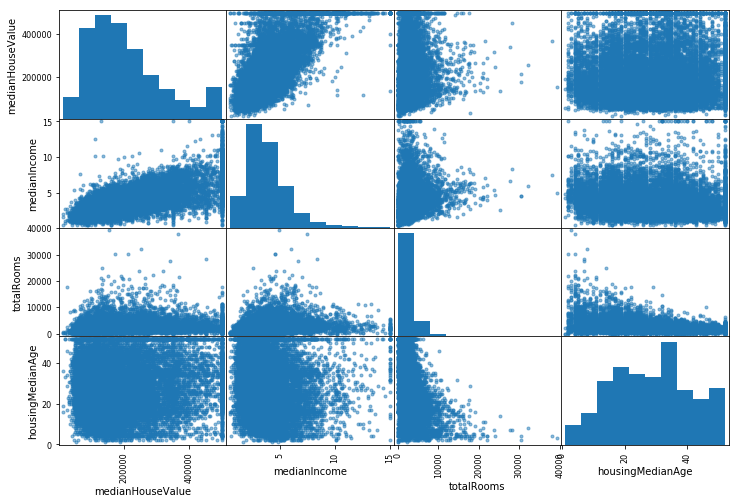

In [116]:
from pandas.tools.plotting import scatter_matrix

attributes = ["medianHouseValue", "medianIncome", "totalRooms", "housingMedianAge"]
scatter_matrix(housing[attributes], figsize=(12,8))

plt.show()

medianIncome definitely seems like it is going to be the best attribute to predict value on.  So let's take a closer look

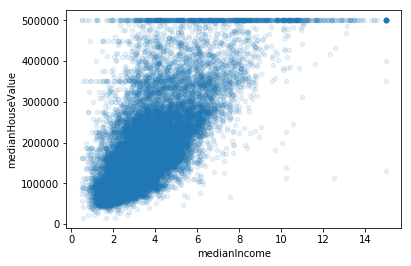

In [117]:
housing.plot(kind="scatter", x="medianIncome", y="medianHouseValue", alpha=0.1)

plt.show()

So we can definitely see here that there is a clear correlation between income and value.  But what is that flat line at 500k?  Well as mentioned before, there is a cap on house value at 500k.  So this is why we get that line.  However, we also see some lines around 450k, 350k, and around 280k (maybe even some below that as well).  Not really sure what those could be though; doesn't look good though

Let's now look at a couple different combos of attributes that could be interesting.
- Total number of rooms by itself isn't very useful since we don't know how many houses there are, so let's combine them into total number of rooms per household (totalRooms/households)
- Total number of bedrooms also doesn't tell us much by itself, but total bedrooms over total rooms would be interesting (totalBedrooms/totalRooms)
- Population per household could also be something interesting to check out (population/household)

In [118]:
housing["roomsPerHousehold"] = housing.totalRooms/housing.households
housing["bedroomsPerRoom"] = housing.totalBedrooms/housing.totalRooms
housing["populationPerHousehold"] = housing.population/housing.households

Now let's check out the correlations

In [119]:
correlationMatrix = housing.corr()

correlationMatrix.medianHouseValue.sort_values(ascending=False)

medianHouseValue          1.000000
medianIncome              0.687160
roomsPerHousehold         0.146285
totalRooms                0.135097
housingMedianAge          0.114110
households                0.064506
totalBedrooms             0.047689
populationPerHousehold   -0.021985
population               -0.026920
longitude                -0.047432
latitude                 -0.142724
bedroomsPerRoom          -0.259984
Name: medianHouseValue, dtype: float64

This definitely helped!  We can now see the bedroomsPerRoom is more correlated than totalRooms and totalBedrooms are individually.  It seems that as the ration of bedrooms to rooms goes down, the value of the home goes up.  We can also see a little correlation with roomsPerHousehold.  As the roomsPerHousehold goes up, so seems our value (just confirms what we know to be already true, in general)

# Prepare the Data 

Let's get a clean dataset of predictors and labels

In [120]:
housing = stratTrainSet.drop("medianHouseValue", axis=1)
housingLabels = stratTrainSet.medianHouseValue.copy()

**Data Cleaning** 

As mentioned before, totalBedrooms is missing some data.  So we need to fix this 1 of 3 ways:
- Gid rid of instances that are missing data
- Get rid of entire attribute (ew..)
- Set values to a value (e.g. zero, mean, median...)

We will choose option 3, and do it using sklearn's Imputer class

In [121]:
from sklearn.preprocessing import Imputer 

# Have to get rid of oceanProximity since it is categorical
housingNumericalFeatures = housing.drop("oceanProximity", axis=1)

imputer = Imputer(strategy="median")
imputer.fit(housingNumericalFeatures)

X = imputer.transform(housingNumericalFeatures)

housingNumericalTransformed = pd.DataFrame(X, columns=housingNumericalFeatures.columns)

In [122]:
housingNumericalTransformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude           16512 non-null float64
latitude            16512 non-null float64
housingMedianAge    16512 non-null float64
totalRooms          16512 non-null float64
totalBedrooms       16512 non-null float64
population          16512 non-null float64
households          16512 non-null float64
medianIncome        16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


So we left out oceanProximity, time to get it back in.  Most ML algorithms prefer numbers so we need to handle this categorical attribute and transform it into numbers using sklearn's LabelEncoder

In [123]:
from sklearn.preprocessing import LabelEncoder

housingCategoricalFeatures = housing.oceanProximity

encoder = LabelEncoder()
housingCategoricalEncoded = encoder.fit_transform(housingCategoricalFeatures)
housingCategoricalEncoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

There is one problem with our newly encoded set, the ML algorithms will think that nearby values are related to one another; which in this dataset is not true.  So we need to split this into binary attributes for each category using sklearn's OneHotEncoder

In [124]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housingCategoricalHotEncoded = encoder.fit_transform(housingCategoricalEncoded.reshape(-1, 1)) # must reshape because it expects a 2d array
housingCategoricalHotEncoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Both of these steps can be done in one shot using LabelBinarizer

**NOTE** LabelBinarizer returns a NumPy array instead of a sparse matrix like OneHotEncoder does.  So to get the sparse matrix, just pass 'sparse_output=True' into the constructor

In [125]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer(sparse_output=True)
housingCategoricalHotEncoded = encoder.fit_transform(housingCategoricalFeatures)
housingCategoricalHotEncoded

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

Let's now create a custom transformer so that we can combine the attributes that we talked about earlier

In [126]:
housing.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'totalRooms',
       'totalBedrooms', 'population', 'households', 'medianIncome',
       'oceanProximity'],
      dtype='object')

In [127]:
from sklearn.base import BaseEstimator, TransformerMixin

totalRoomsIndex, totalBedroomsIndex, populationIndex, householdsIndex = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, addBedroomsPerRoom=True):
        self.addBedroomsPerRoom = addBedroomsPerRoom
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        roomsPerHousehold = X[:, totalRoomsIndex] / X[:, householdsIndex]
        populationPerHousehold = X[:, populationIndex] / X[:, householdsIndex]
        
        if self.addBedroomsPerRoom:
            bedroomsPerRoom = X[:, totalBedroomsIndex] / X[:, totalRoomsIndex]
            
            return np.c_[X, roomsPerHousehold, populationPerHousehold, bedroomsPerRoom]
        else:
            return np.c_[X, roomsPerHousehold, populationPerHousehold]

In [128]:
attributeAdder = CombinedAttributesAdder(addBedroomsPerRoom=False)
housingExtraAttributes = attributeAdder.transform(housing.values)

In [129]:
housingExtraAttributes

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

**Feature Scaling**

For feature scaling we will use standarization.  This way any outliers will not effect us (unlike min max)

Let's create a pipeline that will not only feature scale our values, but fix binarize our categorical data as well

Also, since sklearn doesnt handle dataframes for the selector transformer, we need to build a custom one

In [130]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributeNames):
        self.attributeNames = attributeNames
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributeNames].values

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

numericalAttributes = list(housingNumericalFeatures)
categoricalAttributes = ["oceanProximity"]

numericalPipeline = Pipeline([
    ("selector", DataFrameSelector(numericalAttributes)),
    ("imputer", Imputer(strategy="median")),
    ("attributesAdder", CombinedAttributesAdder()),
    ("standardScaler", StandardScaler())
])

categoricalPipeline = Pipeline([
    ("selector", DataFrameSelector(categoricalAttributes)),
    ("labelBinarizer", LabelBinarizer())
])

fullPipeline = FeatureUnion(transformer_list=[
    ("numericalPipeline", numericalPipeline),
    ("categoricalPipeline", categoricalPipeline)
])

housingPrepared = fullPipeline.fit_transform(housing)

# Short-List Promising Models

Let's test out a few models and see how they perform

**Linear Regression**

In [141]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(housingPrepared, housingLabels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now that we have a model, let's quickly test a few 

In [142]:
someTestData = housing.iloc[:5]
someTestLabels = housingLabels.iloc[:5]

someTestDataPrepared = fullPipeline.transform(someTestData)
someTestPredictions = linReg.predict(someTestDataPrepared)

In [143]:
print(someTestPredictions)
print(list(someTestLabels))

[ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's measure the RMSE of the linReg model

In [145]:
from sklearn.metrics import mean_squared_error

housingPredictions = linReg.predict(housingPrepared)
linRegMse = mean_squared_error(housingLabels, housingPredictions)
linRegRmse = np.sqrt(linRegMse)
linRegRmse

68628.198198489219

Well that's not good.  This is saying our typical error is about \$68,628 off which is terrible.  So we are clearly underfitting and our features give enough info to make good predictions or maybe our model just isn't powerful enough.  We have 3 options:
- Get a more powerful model
- Give better features
- Reduce constraints of model

Let's first try to use a more complex model

**Decision Tree**

In [139]:
from sklearn.tree import DecisionTreeRegressor

treeReg = DecisionTreeRegressor()
treeReg.fit(housingPrepared, housingLabels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [146]:
housingPredictions = treeReg.predict(housingPrepared)
treeRegMse = mean_squared_error(housingLabels, housingPredictions)
treeRegRmse = np.sqrt(treeRegMse)
treeRegRmse

0.0

Whoops.. so since I trained and tested on the same data, I have not just an overfitted model, but a perfectly fit model...  Let's fix this with cross validation

In [157]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(treeReg, housingPrepared, housingLabels, scoring="neg_mean_squared_error", cv=10)
rmseScores = np.sqrt(-scores)

In [158]:
def displayScores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())

In [159]:
displayScores(rmseScores)

Scores:  [ 70450.15263871  67644.58670206  69849.16782573  68364.566869
  71055.56344487  74244.99491179  71782.87450356  69462.81259448
  77247.78195524  69125.56624859]
Mean:  70922.8067694
Std:  2753.70047725


Well this performed like shit.  Worse than the linear regression.  But using cross validation gave us more insight on how well the model works.  Let's do this same test on the linear regression model

In [160]:
scores = cross_val_score(linReg, housingPrepared, housingLabels, scoring="neg_mean_squared_error", cv=10)
rmseScores = np.sqrt(-scores)

In [161]:
displayScores(rmseScores)

Scores:  [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean:  69052.4613635
Std:  2731.6740018


So about the same as what we had (which was expected) but also we get the standard deviation.  But both models seem to not perform well.  Let's try it on one more model

**Random Forest**

In [164]:
from sklearn.ensemble import RandomForestRegressor

forestReg = RandomForestRegressor()
forestReg.fit(housingPrepared, housingLabels)

housingPredictions = forestReg.predict(housingPrepared)
mseScore = mean_squared_error(housingLabels, housingPredictions)
rmseScore = np.sqrt(mseScore)
rmseScore

22393.854246884806

In [165]:
scores = cross_val_score(forestReg, housingPrepared, housingLabels, scoring="neg_mean_squared_error", cv=10)
rmseScores = np.sqrt(-scores)

In [166]:
displayScores(rmseScores)

Scores:  [ 51958.86294854  50287.63345721  50444.40980106  54535.90190471
  51406.6204514   56670.36640332  52057.76871081  50653.40116327
  55736.49223242  52338.19130231]
Mean:  52608.9648375
Std:  2147.85948979


At first, it looked a lot more promissing using random forest.  But as we can see from what we got from cross validation, our model is really overfitting

# Fine-Tune 

Using grid search, we can try to find the best combination of hyperparameters for a model instead of having to manually search through them all.  Let's give it a try to find the best hyperparameters

In [168]:
from sklearn.model_selection import GridSearchCV

paramGrid = [
    { "n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8] },
    { "bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4] }
]

forestReg = RandomForestRegressor()

gridSearch = GridSearchCV(forestReg, paramGrid, cv=5, scoring="neg_mean_squared_error")
gridSearch.fit(housingPrepared, housingLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [170]:
gridSearch.best_params_

{'max_features': 8, 'n_estimators': 30}

In [172]:
cvResults = gridSearch.cv_results_

for meanScore, params in zip(cvResults["mean_test_score"], cvResults["params"]):
    print(np.sqrt(-meanScore), params)

64705.9496931 {'max_features': 2, 'n_estimators': 3}
55136.4515878 {'max_features': 2, 'n_estimators': 10}
53170.8474614 {'max_features': 2, 'n_estimators': 30}
59850.5752164 {'max_features': 4, 'n_estimators': 3}
52984.2292664 {'max_features': 4, 'n_estimators': 10}
50857.9180591 {'max_features': 4, 'n_estimators': 30}
59067.1493233 {'max_features': 6, 'n_estimators': 3}
52266.9072242 {'max_features': 6, 'n_estimators': 10}
50135.8563826 {'max_features': 6, 'n_estimators': 30}
58531.5774153 {'max_features': 8, 'n_estimators': 3}
51956.6178733 {'max_features': 8, 'n_estimators': 10}
50074.0627993 {'max_features': 8, 'n_estimators': 30}
62041.8733923 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54245.0001425 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60165.5916681 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52344.9074914 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58704.1207761 {'bootstrap': False, 'max_features': 4, 'n_estim

# Evaluate 

Let's now find out how well our best model actually did by evaluating it against the actual test set we set aside in the beginning

In [176]:
finalModel = gridSearch.best_estimator_

XTest = stratTestSet.drop("medianHouseValue", axis=1)
yTest = stratTestSet.medianHouseValue.copy()

XTestPrepared = fullPipeline.transform(XTest)

finalPredictions = finalModel.predict(XTestPrepared)

finalMse = mean_squared_error(yTest, finalPredictions)
finalRmse = np.sqrt(finalMse)

finalRmse

48160.785116912877